In [1]:
import numpy as np
import pandas as pd
import os
from matplotlib.pyplot import *
import h5py

from ATARI.syndat.particle_pair import Particle_Pair
from ATARI.syndat.experiment import Experiment
from ATARI.syndat.MMDA import generate
import ATARI.atari_io.internal as ioi
from ATARI.theory.xs import SLBW
from ATARI.theory.scattering_params import FofE_recursive
from ATARI.theory.scattering_params import gstat
import scipy.stats as sts

from numpy.linalg import inv
from scipy.linalg import block_diag

from scipy.optimize import lsq_linear
from qpsolvers import solve_qp

import functions as fn 


In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [3]:
%matplotlib widget

In [4]:

def gn2G(row):
    S, P, phi, k = FofE_recursive([row.E], Ta_pair.ac, Ta_pair.M, Ta_pair.m, row.lwave)
    Gnx = 2*np.sum(P)*row.gnx2
    return Gnx.item()

def G2gn(row):
    S, P, phi, k = FofE_recursive([row.E], Ta_pair.ac, Ta_pair.M, Ta_pair.m, row.lwave)
    gnx2 = row.Gnx/2/np.sum(P)
    return gnx2.item()


#%%
ac = 0.81271  # scattering radius in 1e-12 cm 
M = 180.948030  # amu of target nucleus
m = 1           # amu of incident neutron
I = 3.5         # intrinsic spin, positive parity
i = 0.5         # intrinsic spin, positive parity
l_max = 1       # highest order l-wave to consider


Ta_pair = Particle_Pair( ac, M, m, I, i, l_max,
                                input_options={})



spin_groups = [ (3.0,1,0)] # , (4.0,1,[0]) ]
average_parameters = pd.DataFrame({ 'dE'    :   {'3.0':8.79, '4.0':4.99},
                                    'Gg'    :   {'3.0':64.0, '4.0':64.0},
                                    'gn2'    :   {'3.0':46.4, '4.0':35.5}  })


E_min_max = [550, 600]
energy_grid = E_min_max

input_options = {'Add Noise': True,
                'Calculate Covariance': True,
                'Compression Points':[],
                'Grouping Factors':None}

experiment_parameters = {'bw': {'val':0.0256,    'unc'   :   0}}

# initialize experimental setup
exp = Experiment(energy_grid, 
                        input_options=input_options, 
                        experiment_parameters=experiment_parameters)


# resonance_ladder = Ta_pair.sample_resonance_ladder(E_min_max, spin_groups, average_parameters, False)
resonance_ladder = pd.DataFrame({'E':[570], 'J':[3.0], 'chs':[1.0], 'lwave':[0.0], 'J_ID':[1.0], 'gnx2':[100], 'Gg':[750]})
Gnx = resonance_ladder.apply(lambda row: gn2G(row), axis=1)
resonance_ladder['Gt'] = Gnx + resonance_ladder['Gg']

print(resonance_ladder)

true, _, _ = SLBW(exp.energy_domain, Ta_pair, resonance_ladder)
df_true = pd.DataFrame({'E':exp.energy_domain, 'theo_trans':np.exp(-exp.redpar.val.n*true)})

# resonance_ladder
exp.run(df_true)

# figure()
# plot(exp.trans.E, exp.trans.exp_trans, '.')
# plot(exp.theo.E, exp.theo.theo_trans)
# axhline(0)

     E    J  chs  lwave  J_ID  gnx2   Gg          Gt
0  570  3.0  1.0    0.0   1.0   100  750  758.478159


In [5]:
average_parameters

,dE,Gg,gn2
3.0,8.79,64.0,46.4
4.0,4.99,64.0,35.5


In [6]:

average_parameters.loc[:,['Gn']] = average_parameters['gn2']/12.5

Elam_features, Gtot_features = fn.get_parameter_grid(energy_grid, average_parameters, '3.0', 1e-1, 1e-2)
# Elam_features, 
Gtot_features = [0.755, 0.758, 0.760]
# print(Elam_features, Gtot_features)
print(Gtot_features)
print(len(Elam_features)*len(Gtot_features))

E = np.sort(exp.energy_domain)
Resonance_Matrix, potential_scattering = fn.get_resonance_matrix(E, Ta_pair, Elam_features, Gtot_features)
nfeatures = np.shape(Resonance_Matrix)[1]

# sort everything
CovT = np.flip(exp.CovT)
exp.trans.sort_values('E', inplace=True)
exp.theo.sort_values('E', inplace=True)

# convert to xs - linear error propagation is not exact
exp, CovXS, Lxs = fn.convert_2_xs(exp, CovT)

[0.755, 0.758, 0.76]
1503


In [7]:
# average_parameters.loc[:,['Gn']] = average_parameters['gn2']/12.5

# Elam_features, Gtot_features = fn.get_parameter_grid(energy_grid, average_parameters, '3.0', 1e-1, 1e-2)
# # Elam_features, Gtot_features = [565, 569, 570, 571, 575], [.7585]
# # print(Elam_features, Gtot_features)

# E = np.sort(exp.energy_domain)
# Resonance_Matrix, potential_scattering = fn.get_resonance_matrix(E, Ta_pair, Elam_features, Gtot_features)
# nfeatures = np.shape(Resonance_Matrix)[1]; print(nfeatures)

# # sort everything
# CovT = np.flip(exp.CovT)
# exp.trans.sort_values('E', inplace=True)
# exp.theo.sort_values('E', inplace=True)

# # convert to xs - linear error propagation is not exact
# exp, CovXS, Lxs = fn.convert_2_xs(exp, CovT)

In [8]:
# setup
b = (np.array(exp.trans.exp_xs)-potential_scattering).flatten()
A = Resonance_Matrix
lb, ub = fn.get_bound_arrays(nfeatures, 0, 1)

# Cast into linear least squares
bp = Lxs.T @ b
Ap = Lxs.T @ A
# Cast into quadratic program 
P = A.T @ inv(CovXS) @ A
q = - A.T @ inv(CovXS) @ b

# solve 
# res_ls = lsq_linear(Ap, bp, bounds=(lb,ub), 
#                             lsmr_tol='auto', 
#                             lsq_solver='lsmr',
#                             max_iter = 500, 
#                             verbose=1)

qp_res = solve_qp(P, q, G=None, h=None, A=None, b=None, lb=lb, ub=ub, 
                                                        solver="cvxopt",
                                                        verbose=False,
                                                        # abstol=1e-15,
                                                        # reltol=1e-15,
                                                        # feastol= 1e-13,
                                                        # maxiters = 100, 
                                                        # refinement = 10
                                                                            )

# print(Elam_features)
# print(res_ls.x)
# print(qp_res)

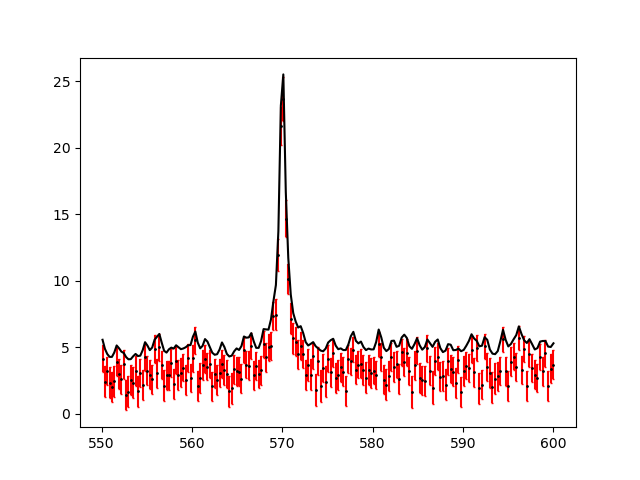

In [9]:
# print(Elam_features)
# print(res_ls.x)
# print(res_qp.x)
# print(qp_x)


figure()
errorbar(exp.trans.E, exp.trans.exp_xs, yerr=np.sqrt(np.diag(CovXS)), fmt='.', ecolor='r', color='k', capsize=1, ms=2)
# plot(E, Resonance_Matrix@res_ls.x+potential_scattering.flatten(), lw=5, color='cornflowerblue')
plot(E, Resonance_Matrix@qp_res+potential_scattering.flatten(), color='k')

# figure()
# bins = hist(np.log10(qp_res), bins=100)

### Now add constraints

In [10]:
from ATARI.utils.stats import chi2_val

print(sum(qp_res))

basename = '/Users/noahwalton/research_local/resonance_fitting/ATARI_workspace/SLBW_noexp/figures/'


0.04373724912951747


In [11]:
# x_constrained = []

# for fac in np.linspace(0,1,50):
#     G = np.ones(len(qp_res))
#     h = np.array([[sum(qp_res)*fac]])

#     # qp_x_c = solve_qp(P, q, G=G, h=h, A=None, b=None, lb=lb, ub=ub, solver="cvxopt")
#     qp_x_c = solve_qp(P, q, G=G, h=h, A=None, b=None, lb=lb, ub=ub, 
#                                                         solver="cvxopt",
#                                                         verbose=False,
#                                                         abstol=1e-12,
#                                                         reltol=1e-10,
#                                                         feastol= 1e-8,
#                                                         maxiters = 500)
    
#     x_constrained.append(qp_x_c)


# ws_vs_factor = np.array(x_constrained)

# np.save('wvfactor_test.npy',ws_vs_factor)
# np.save( 'factors.npy',factors)

In [12]:

def get_resonance_ladder_from_matrix(weights, Elam_features, Gtot_features, threshold):
    feature_indices = np.argwhere(weights>threshold).flatten()
    resonances = []
    for ifeature in feature_indices:
        Efeature_index, Gfeature_index = divmod(ifeature, len(Gtot_features))
        Elam = Elam_features[Efeature_index]
        Gt = Gtot_features[Gfeature_index]*1e3
        w = weights[ifeature]
        Gnx = Gt*w
        Gg = Gt-Gnx
        resonances.append([Elam, Gt, Gnx, Gg, w])
    resonance_ladder = pd.DataFrame(resonances, columns=['E', 'Gt', 'Gnx', 'Gg', 'w'])
    return resonance_ladder


In [13]:
case = 'test'
ws_vs_factor =  np.load(f'wvfactor_{case}.npy')
factors = np.repeat(np.atleast_2d(np.linspace(0,1,50)), len(ws_vs_factor.T), axis=0)  

# # factors = np.load('factors.npy')
# factors = np.repeat(np.atleast_2d(np.linspace(0,1,50)), len(ws_vs_factor.T), axis=0)  


FileNotFoundError: [Errno 2] No such file or directory: 'wvfactor_test.npy'

In [ ]:
from ATARI.utils.misc import fine_egrid
from scipy.integrate import trapezoid


def calculate_integral_FoMs(weights, Elam_features, Gtot_features, threshold):
    est_resonance_ladder = get_resonance_ladder_from_matrix(weights, Elam_features, Gtot_features, threshold)
    est_resonance_ladder = ioi.fill_resonance_ladder(est_resonance_ladder, Ta_pair, J=3.0, chs=1.0, lwave=0.0, J_ID=1.0)

    xs = Resonance_Matrix@ws_vs_factor[9]+potential_scattering.flatten()
    trans = np.exp(-exp.redpar.val.n*xs)

    fineE = fine_egrid(E, 1e2)
    est_xs_tot, _, _ = SLBW(fineE, Ta_pair, est_resonance_ladder)
    theo_xs_tot, _, _ = SLBW(fineE, Ta_pair, resonance_ladder)
    MSE = trapezoid((est_xs_tot-theo_xs_tot)**2, fineE)
    bias = est_xs_tot-theo_xs_tot

    return MSE, bias


In [ ]:

chi2 = []
chi2_trans = []
nonzero = []; threshold = 1e-10
MSE_list = []
mean_bias = []
std_bias = []

for ifac, fac in enumerate(np.linspace(0,1,50)):

    ### make hist for gif
    # figure()
    # bins = hist(np.log10(ws_vs_factor[ifac]), bins=100)
    # title(f'Factor: {fac}')
    # savefig(os.path.join(basename,'constrain_w_giffigs', f'histwf_{case}_{ifac}.png'))
    # close()

    ### calculate chi2
    xs = Resonance_Matrix@ws_vs_factor[ifac]+potential_scattering.flatten()
    trans = np.exp(-exp.redpar.val.n*xs)
    chi2_trans.append( chi2_val(trans, exp.trans.exp_trans, CovT).flatten() )
    chi2.append(chi2_val(xs, exp.trans.exp_xs, CovXS).flatten())
    nonzero.append(np.count_nonzero(ws_vs_factor[ifac]>threshold))

    MSE, bias = calculate_integral_FoMs(ws_vs_factor[ifac], Elam_features, Gtot_features, 1e-10)
    MSE_list.append(MSE)
    mean_bias.append(np.mean(abs(bias)))
    std_bias.append(np.std(abs(bias)))

    ### make hist for gif
    # fig, axes = subplots(1,2, figsize=(10,5))
    # axes[0].errorbar(exp.trans.E, exp.trans.exp_xs, yerr=np.sqrt(np.diag(CovXS)), fmt='.', ecolor='r', color='k', capsize=1, ms=2)
    # axes[0].plot(E, xs, color='g')
    # axes[1].errorbar(exp.trans.E, exp.trans.exp_trans, yerr=np.sqrt(np.diag(CovT)), fmt='.', ecolor='r', color='k', capsize=1, ms=2)
    # axes[1].plot(E, trans, color='g')
    # title(f'Factor: {fac}')
    # savefig(os.path.join(basename,'constrain_w_giffigs', f'xstrans_{case}_{ifac}.png'))
    # close()


chi2 = np.array(chi2)
chi2_trans = np.array(chi2_trans)
nonzero = np.array(nonzero)
MSE_list = np.array(MSE_list)
mean_bias = np.array(mean_bias)
std_bias = np.array(std_bias)

### Spaghetti plot of weights vs factor
# figure(figsize=(10,5))
# out = plot(factors.T, np.log10(ws_vs_factor))
# ylabel('Log10(w)')
# xlabel('Factor')

# import imageio
# # histfigs = []
# xstransfigs = []
# for job_number in range(len(ws_vs_factor)-1, 0 , -1): 
#     # hhistfigsist.append(imageio.imread(os.path.join(basename, 'constrain_w_giffigs', f'histwf_ineq_lowtol_{job_number}.png')))
#     xstransfigs.append(imageio.imread(os.path.join(basename, 'constrain_w_giffigs', f'xstrans_{case}_{job_number}.png')))
# # imageio.mimsave(os.path.join(basename, f'histwf_{case}.gif'), histfigs)
# imageio.mimsave(os.path.join(basename, f'xstrans_{case}.gif'), xstransfigs)

Text(0, 0.5, 'Non-zero resonances')

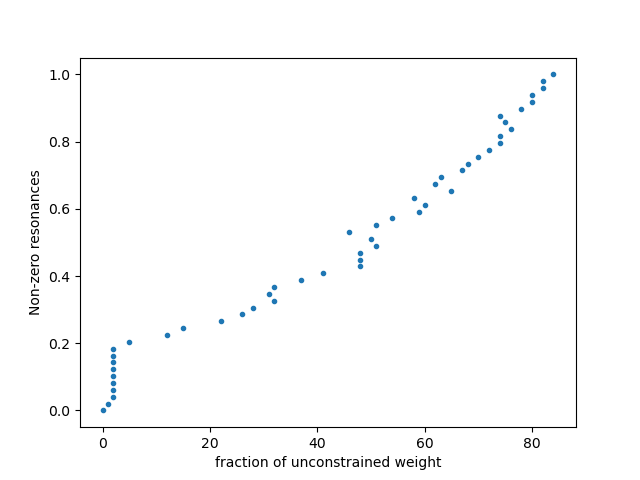

In [ ]:
# np.shape(chi2.flatten()/(len(E)-nonzero))
figure()
# plot(np.linspace(0,1,50), nonzero)
plot(nonzero, np.linspace(0,1,50), '.')
xlabel('fraction of unconstrained weight')
ylabel('Non-zero resonances')

/var/folders/s9/xdv2y9hs0y7g3zzscy35rz4c0000gn/T/ipykernel_68061/502392316.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = subplots(1,2, figsize=(10,4), sharex=True, sharey=True)


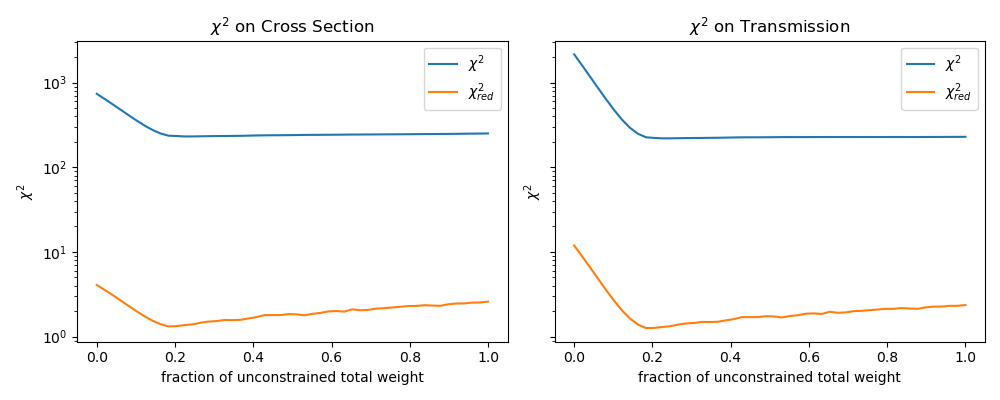

In [ ]:
fig, axes = subplots(1,2, figsize=(10,4), sharex=True, sharey=True)

axes[0].plot(np.linspace(0,1,50), chi2.flatten(), label=r'$\chi^2$')
axes[0].plot(np.linspace(0,1,50), chi2.flatten()/(len(E)-nonzero), label=r'$\chi^2_{red}$')
axes[1].plot(np.linspace(0,1,50), chi2_trans.flatten(), label=r'$\chi^2$')
axes[1].plot(np.linspace(0,1,50), chi2_trans.flatten()/(len(E)-nonzero), label=r'$\chi^2_{red}$')

# axes[2].plot(np.linspace(0,1,50), chi2.flatten()/(len(E)-nonzero*3), label=r'$\chi^2_{\sigma}$')
# axes[2].plot(np.linspace(0,1,50), chi2_trans.flatten()/(len(E)-nonzero*3), label=r'$\chi^2_{trans}$')


# for ax in axes[0:2]:
#     ax.set_yscale('log')
#     # ax.set_xscale('log')
for ax in axes:
    ax.set_yscale('log')
    ax.set_xlabel('fraction of unconstrained total weight')
    ax.set_ylabel(r'$\chi^2$')
    ax.legend()

# axes[0].set_ylabel(r'$\chi^2$')
axes[0].set_title(r'$\chi^2$ on Cross Section')
axes[1].set_title(r'$\chi^2$ on Transmission')
# axes[2].set_title(r'$\chi^2_{red}$ with dof=#respar')
fig.tight_layout()

In [ ]:
fig, axes = subplots(1,2, figsize=(10,4), sharex=True)

axes[0].plot(np.linspace(0,1,50), MSE_list.flatten(), label='MSE')
axes[1].plot(np.linspace(0,1,50), mean_bias.flatten()+std_bias.flatten(), label='68% quantile in bias')
axes[1].axvline(E[np.argwhere(min(chi2_trans.flatten()))], label=r'$\chi^2$')

for ax in axes:
    ax.legend()
    ax.set_yscale('log')
    ax.set_xlabel('fraction of unconstrained total weight')

fig.tight_layout()